In [6]:
# ==============================================================================
# 2. IMPORT LIBRARY YANG DIBUTUHKAN
# ==============================================================================
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    Trainer,
    TrainingArguments,
)

In [7]:
# ==============================================================================
# 3. PERSIAPAN DATA (VERSI BERSIH)
# ==============================================================================
import pandas as pd
from sklearn.model_selection import train_test_split

try:
    df = pd.read_csv(r'D:\INDONERIS-DATAMINING\multimodal-hoax-detection\data\training\multimodal_splits\text_only_dataset.csv')
    print(f"Data awal dimuat. Jumlah baris: {len(df)}")
except FileNotFoundError:
    print("Error: Pastikan file 'text_only_dataset.csv' sudah di-upload.")

df_cleaned = df.drop_duplicates(subset=['title'])
print(f"Data setelah dibersihkan dari duplikat judul. Jumlah baris: {len(df_cleaned)}")
df_cleaned = df_cleaned[['title', 'label']].copy()

label_map = {'valid': 1, 'hoax': 0}
df_cleaned['labels'] = df_cleaned['label'].map(label_map)

df_train, df_val = train_test_split(
    df_cleaned,
    test_size=0.2,
    random_state=42,
    stratify=df_cleaned['labels']
)

print(f"Jumlah data latih bersih: {len(df_train)}")
print(f"Jumlah data evaluasi bersih: {len(df_val)}")

Data awal dimuat. Jumlah baris: 3276
Data setelah dibersihkan dari duplikat judul. Jumlah baris: 3270
Jumlah data latih bersih: 2616
Jumlah data evaluasi bersih: 654


In [8]:
# ==============================================================================
# 4. TOKENISASI DATA
# ==============================================================================
MODEL_NAME = 'indobenchmark/indobert-base-p1'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def tokenize_data(examples):
    return tokenizer(examples['title'], padding='max_length', truncation=True, max_length=128)

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_texts = df_train['title'].tolist()
val_texts = df_val['title'].tolist()
train_labels = df_train['labels'].tolist()
val_labels = df_val['labels'].tolist()

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

In [9]:
# ==============================================================================
# 5. MEMBANGUN DAN MELATIH MODEL
# ==============================================================================

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Memindahkan model ke device: {device}")
model.to(device)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

print("Memulai pelatihan model...")
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Memindahkan model ke device: cuda
Memulai pelatihan model...


  0%|          | 0/1635 [00:00<?, ?it/s]

{'loss': 0.6659, 'grad_norm': 4.108010768890381, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.03}
{'loss': 0.701, 'grad_norm': 6.129114151000977, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.06}


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


{'loss': 0.6202, 'grad_norm': 5.450953006744385, 'learning_rate': 3e-06, 'epoch': 0.09}


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

{'loss': 0.6253, 'grad_norm': 4.850326061248779, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.12}
{'loss': 0.641, 'grad_norm': 13.866495132446289, 'learning_rate': 5e-06, 'epoch': 0.15}
{'loss': 0.5741, 'grad_norm': 5.8039679527282715, 'learning_rate': 6e-06, 'epoch': 0.18}
{'loss': 0.5154, 'grad_norm': 5.355584144592285, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.21}
{'loss': 0.4314, 'grad_norm': 6.7197418212890625, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.24}
{'loss': 0.37, 'grad_norm': 3.5709879398345947, 'learning_rate': 9e-06, 'epoch': 0.28}
{'loss': 0.2389, 'grad_norm': 5.1712327003479, 'learning_rate': 1e-05, 'epoch': 0.31}
{'loss': 0.4276, 'grad_norm': 12.34533405303955, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.34}
{'loss': 0.4329, 'grad_norm': 7.2472147941589355, 'learning_rate': 1.2e-05, 'epoch': 0.37}
{'loss': 0.3726, 'grad_norm': 6.784069061279297, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.4}
{'loss': 0.3663, 'grad_norm': 11.2244

  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.2522038221359253, 'eval_accuracy': 0.9159021406727829, 'eval_f1': 0.9349112426035503, 'eval_precision': 0.9059633027522935, 'eval_recall': 0.9657701711491442, 'eval_runtime': 3.6695, 'eval_samples_per_second': 178.225, 'eval_steps_per_second': 22.346, 'epoch': 1.0}
{'loss': 0.2617, 'grad_norm': 8.441376686096191, 'learning_rate': 3.3e-05, 'epoch': 1.01}
{'loss': 0.3088, 'grad_norm': 2.9806277751922607, 'learning_rate': 3.4000000000000007e-05, 'epoch': 1.04}
{'loss': 0.2511, 'grad_norm': 3.0435473918914795, 'learning_rate': 3.5e-05, 'epoch': 1.07}
{'loss': 0.1678, 'grad_norm': 29.976621627807617, 'learning_rate': 3.6e-05, 'epoch': 1.1}
{'loss': 0.355, 'grad_norm': 10.543965339660645, 'learning_rate': 3.7e-05, 'epoch': 1.13}


d:\INDONERIS-DATAMINING\multimodal-hoax-detection\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--indobenchmark--indobert-base-p1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


{'loss': 0.1827, 'grad_norm': 38.037940979003906, 'learning_rate': 3.8e-05, 'epoch': 1.16}
{'loss': 0.3564, 'grad_norm': 18.379465103149414, 'learning_rate': 3.9000000000000006e-05, 'epoch': 1.19}
{'loss': 0.1948, 'grad_norm': 23.206958770751953, 'learning_rate': 4e-05, 'epoch': 1.22}
{'loss': 0.3757, 'grad_norm': 0.9347841143608093, 'learning_rate': 4.1e-05, 'epoch': 1.25}
{'loss': 0.3148, 'grad_norm': 0.31659945845603943, 'learning_rate': 4.2e-05, 'epoch': 1.28}
{'loss': 0.0751, 'grad_norm': 1.0685566663742065, 'learning_rate': 4.3e-05, 'epoch': 1.31}
{'loss': 0.6313, 'grad_norm': 37.303062438964844, 'learning_rate': 4.4000000000000006e-05, 'epoch': 1.35}
{'loss': 0.1863, 'grad_norm': 8.76660442352295, 'learning_rate': 4.5e-05, 'epoch': 1.38}
{'loss': 0.3936, 'grad_norm': 22.03896713256836, 'learning_rate': 4.600000000000001e-05, 'epoch': 1.41}
{'loss': 0.249, 'grad_norm': 0.5339524149894714, 'learning_rate': 4.7e-05, 'epoch': 1.44}
{'loss': 0.3076, 'grad_norm': 10.629149436950684, '

  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.28045281767845154, 'eval_accuracy': 0.9128440366972477, 'eval_f1': 0.9304029304029304, 'eval_precision': 0.9292682926829269, 'eval_recall': 0.9315403422982885, 'eval_runtime': 3.6368, 'eval_samples_per_second': 179.827, 'eval_steps_per_second': 22.547, 'epoch': 2.0}
{'loss': 0.2707, 'grad_norm': 4.144132137298584, 'learning_rate': 4.295154185022027e-05, 'epoch': 2.02}
{'loss': 0.2281, 'grad_norm': 10.964900970458984, 'learning_rate': 4.251101321585903e-05, 'epoch': 2.05}
{'loss': 0.07, 'grad_norm': 0.20828558504581451, 'learning_rate': 4.20704845814978e-05, 'epoch': 2.08}
{'loss': 0.2128, 'grad_norm': 35.036983489990234, 'learning_rate': 4.1629955947136564e-05, 'epoch': 2.11}
{'loss': 0.0817, 'grad_norm': 0.08582307398319244, 'learning_rate': 4.118942731277533e-05, 'epoch': 2.14}
{'loss': 0.068, 'grad_norm': 38.62294387817383, 'learning_rate': 4.07488986784141e-05, 'epoch': 2.17}
{'loss': 0.1373, 'grad_norm': 0.057040270417928696, 'learning_rate': 4.030837004405287e-05,

  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.36515653133392334, 'eval_accuracy': 0.9235474006116208, 'eval_f1': 0.9394673123486683, 'eval_precision': 0.9304556354916067, 'eval_recall': 0.9486552567237164, 'eval_runtime': 3.7155, 'eval_samples_per_second': 176.021, 'eval_steps_per_second': 22.07, 'epoch': 3.0}
{'loss': 0.1795, 'grad_norm': 0.01792575977742672, 'learning_rate': 2.841409691629956e-05, 'epoch': 3.03}
{'loss': 0.0822, 'grad_norm': 0.036985140293836594, 'learning_rate': 2.7973568281938327e-05, 'epoch': 3.06}
{'loss': 0.015, 'grad_norm': 0.037980638444423676, 'learning_rate': 2.753303964757709e-05, 'epoch': 3.09}
{'loss': 0.0321, 'grad_norm': 0.035503409802913666, 'learning_rate': 2.709251101321586e-05, 'epoch': 3.12}
{'loss': 0.0048, 'grad_norm': 0.034495532512664795, 'learning_rate': 2.6651982378854628e-05, 'epoch': 3.15}
{'loss': 0.0374, 'grad_norm': 0.022797169163823128, 'learning_rate': 2.621145374449339e-05, 'epoch': 3.18}
{'loss': 0.0319, 'grad_norm': 0.2187068909406662, 'learning_rate': 2.5770925

  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.47268643975257874, 'eval_accuracy': 0.9159021406727829, 'eval_f1': 0.93099121706399, 'eval_precision': 0.9561855670103093, 'eval_recall': 0.9070904645476773, 'eval_runtime': 3.7582, 'eval_samples_per_second': 174.019, 'eval_steps_per_second': 21.819, 'epoch': 4.0}
{'loss': 0.0003, 'grad_norm': 0.00720247533172369, 'learning_rate': 1.4317180616740089e-05, 'epoch': 4.01}
{'loss': 0.0004, 'grad_norm': 0.11552219092845917, 'learning_rate': 1.3876651982378854e-05, 'epoch': 4.04}
{'loss': 0.0004, 'grad_norm': 0.04103753715753555, 'learning_rate': 1.3436123348017621e-05, 'epoch': 4.07}
{'loss': 0.0009, 'grad_norm': 0.005003790371119976, 'learning_rate': 1.299559471365639e-05, 'epoch': 4.1}
{'loss': 0.0003, 'grad_norm': 0.015665268525481224, 'learning_rate': 1.2555066079295155e-05, 'epoch': 4.13}
{'loss': 0.0017, 'grad_norm': 0.030738718807697296, 'learning_rate': 1.211453744493392e-05, 'epoch': 4.16}
{'loss': 0.0002, 'grad_norm': 0.004544820636510849, 'learning_rate': 1.167400

  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.46709561347961426, 'eval_accuracy': 0.9235474006116208, 'eval_f1': 0.9379652605459057, 'eval_precision': 0.9521410579345088, 'eval_recall': 0.9242053789731052, 'eval_runtime': 3.5933, 'eval_samples_per_second': 182.006, 'eval_steps_per_second': 22.82, 'epoch': 5.0}
{'train_runtime': 402.3725, 'train_samples_per_second': 32.507, 'train_steps_per_second': 4.063, 'train_loss': 0.18346603865221153, 'epoch': 5.0}


TrainOutput(global_step=1635, training_loss=0.18346603865221153, metrics={'train_runtime': 402.3725, 'train_samples_per_second': 32.507, 'train_steps_per_second': 4.063, 'total_flos': 235258283484000.0, 'train_loss': 0.18346603865221153, 'epoch': 5.0})

In [10]:
# ==============================================================================
# 6. EVALUASI MODEL
# ==============================================================================
print("Pelatihan selesai. Mengevaluasi model...")
eval_results = trainer.evaluate()

print("\n--- Hasil Evaluasi Akhir ---")
print(f"Akurasi: {eval_results['eval_accuracy']:.4f}")
print(f"F1 Score: {eval_results['eval_f1']:.4f}")
print(f"Precision: {eval_results['eval_precision']:.4f}")
print(f"Recall: {eval_results['eval_recall']:.4f}")

Pelatihan selesai. Mengevaluasi model...


  0%|          | 0/82 [00:00<?, ?it/s]


--- Hasil Evaluasi Akhir ---
Akurasi: 0.9159
F1 Score: 0.9349
Precision: 0.9060
Recall: 0.9658


Mendapatkan prediksi dari model pada data evaluasi...


  0%|          | 0/82 [00:00<?, ?it/s]


Skor AUC-ROC: 0.9675
Nama kelas untuk grafik (Urutan 0, 1): ['hoax', 'valid']


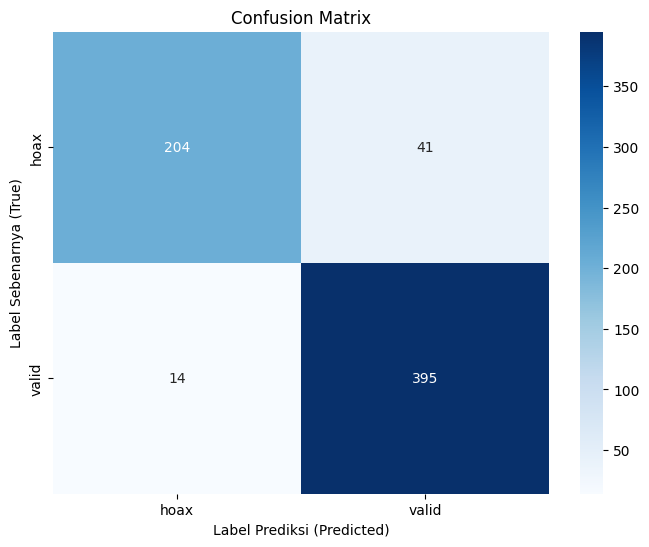

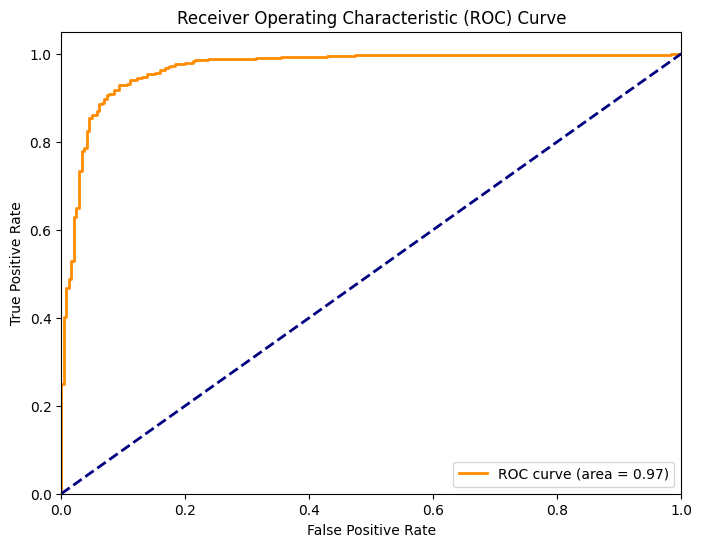

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from scipy.special import softmax
import pandas as pd


label_map = {'valid': 1, 'hoax': 0}

print("Mendapatkan prediksi dari model pada data evaluasi...")
pred_results = trainer.predict(val_dataset)

true_labels = pred_results.label_ids
logits = pred_results.predictions

predicted_classes = np.argmax(logits, axis=1)

probabilities = softmax(logits, axis=1)
proba_positive_class = probabilities[:, 1]

auc_score = roc_auc_score(true_labels, proba_positive_class)
print(f"\nSkor AUC-ROC: {auc_score:.4f}")


reverse_label_map = {v: k for k, v in label_map.items()}
class_names = [reverse_label_map[0], reverse_label_map[1]]
print(f"Nama kelas untuk grafik (Urutan 0, 1): {class_names}")

try:
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(true_labels, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Label Sebenarnya (True)')
    plt.xlabel('Label Prediksi (Predicted)')

    fpr, tpr, thresholds = roc_curve(true_labels, proba_positive_class)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

except Exception as e:
    print(f"\nTerjadi error saat membuat plot: {e}")

In [12]:
# ==============================================================================
# 7. (OPSIONAL) MENCOBA PREDIKSI
# ==============================================================================

text_berita_baru = "Menkeu Purbaya Jebloskan Luhut ke Penjara"
text_berita_valid = "Tokoh Muslimat NU Arifatul Choiri Fauzi Jadi Menteri PPPA Kabinet Prabowo-Gibran"

def prediksi_berita(teks):
    inputs = tokenizer(teks, return_tensors='pt', truncation=True, padding=True, max_length=256)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    prediksi_angka = torch.argmax(logits, dim=-1).item()

    reverse_label_map = {v: k for k, v in label_map.items()}

    return reverse_label_map[prediksi_angka]

print("\n--- Mencoba Prediksi ---")
print(f"Teks: '{text_berita_baru}' -> Prediksi: {prediksi_berita(text_berita_baru)}")
print(f"Teks: '{text_berita_valid[:50]}...' -> Prediksi: {prediksi_berita(text_berita_valid)}")


--- Mencoba Prediksi ---
Teks: 'Menkeu Purbaya Jebloskan Luhut ke Penjara' -> Prediksi: hoax
Teks: 'Tokoh Muslimat NU Arifatul Choiri Fauzi Jadi Mente...' -> Prediksi: valid


In [13]:
# ==============================================================================
# SIMPAN MODEL
# ==============================================================================

MODEL_TITLE_PATH = r"D:\INDONERIS-DATAMINING\multimodal-hoax-detection\models\text_baseline/indobert-base-p1"

print(f"Menyimpan model 'title' (Akurasi 91.9%) ke folder {MODEL_TITLE_PATH}...")

try:
    trainer.save_model(MODEL_TITLE_PATH)
    tokenizer.save_pretrained(MODEL_TITLE_PATH)
    print("Model dan Tokenizer 'title' berhasil disimpan!")
    print(f"Folder Anda '{MODEL_TITLE_PATH}' sekarang siap di-download.")
except NameError:
    print("Error: 'trainer' atau 'tokenizer' tidak ditemukan.")
    print("Pastikan Anda baru saja menyelesaikan pelatihan 'title' di notebook ini.")


Menyimpan model 'title' (Akurasi 91.9%) ke folder D:\INDONERIS-DATAMINING\multimodal-hoax-detection\models\text_baseline/indobert-base-p1...
Model dan Tokenizer 'title' berhasil disimpan!
Folder Anda 'D:\INDONERIS-DATAMINING\multimodal-hoax-detection\models\text_baseline/indobert-base-p1' sekarang siap di-download.
